In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
# just here as it is subfolder in experimental
os.pardir = '../..'

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt

# new for this
import importlib
from gempy.assets import kriging

In [6]:
path_to_data = os.pardir+"/data/input_data/jan_models/"

geo_data = gp.create_data([0,1000,0,10,0,1000],resolution=[200,2,200], 
                        path_o = path_to_data + "model2_orientations.csv",
                        path_i = path_to_data + "model2_surface_points.csv") 

Active grids: ['regular']


In [7]:
#geo_data.get_data('kriging')
#geo_data.additional_data.kriging_data.modify_kriging_parameters('nugget grad', 0)
#geo_data.additional_data.kriging_data.modify_kriging_parameters('nugget scalar', 0)
#gp.update_additional_data

In [10]:
#gp.map_series_to_surfaces(geo_data, {"Fault_Series": ('fault'), "Strat_Series1": ('rock3'),
#                                     "Strat_Series2": ('rock2','rock1'),
#                                     "Basement_Series":('basement')})

gp.map_series_to_surfaces(geo_data, {"Strat_Series": ('rock2','rock1'),
                                        "Basement_Series":('basement')})

#geo_data.set_is_fault(['Fault_Series'])

,surface,series,order_surfaces,isBasement,color,id
0,rock1,Strat_Series,1,False,#015482,1
1,rock2,Strat_Series,2,False,#9f0052,2
2,basement,Basement_Series,1,True,#ffbe00,3


In [11]:
#geo_data.surfaces.colors.change_colors({'fault': '#000000', 'rock1': '#CC081F', 'rock2': '#FFAA00',
#                                        'rock3': '#006C8C', 'basement': '#097703'})

#geo_data.surfaces.colors.change_colors({'fault': '#000000', 'rock1': '#E1E1E1', 'rock2': '#B1B1B1',
                                        #'rock3': '#4B4B4B', 'basement': '#7B7B7B'})
    
geo_data.surfaces

,surface,series,order_surfaces,isBasement,color,id
0,rock1,Strat_Series,1,False,#015482,1
1,rock2,Strat_Series,2,False,#9f0052,2
2,basement,Basement_Series,1,True,#ffbe00,3


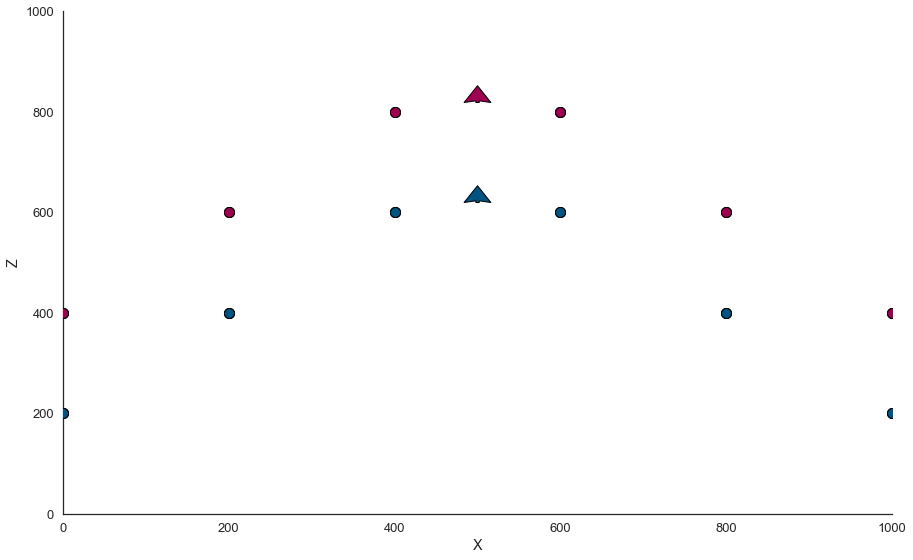

In [12]:
%matplotlib inline
gp.plot.plot_data(geo_data, direction='y')

In [13]:
interp_data = gp.set_interpolation_data(geo_data, theano_optimizer='fast_compile')

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!


In [14]:
sol = gp.compute_model(geo_data)

../../..\gempy\core\solution.py:257: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


In [15]:
#geo_data.add_topography(source='random')

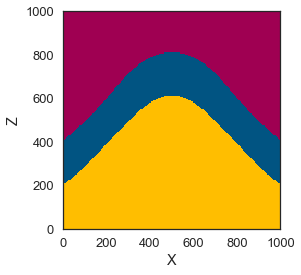

In [16]:
%matplotlib inline
gp.plot.plot_section(geo_data, cell_number=1,
                         direction='y', show_data=True)

# Kriging test

In [17]:
# conditioning data (data measured at locations)
cond_data = np.array([[100,.5,500,20],[900,.5,500,20],[500,.5,550,20],[300,.5,400,20]])

domain = kriging.domain(model=sol, domain=[4], data=cond_data)

variogram_model = kriging.variogram_model(theoretical_model = 'exponential', 
                                          range_=300, sill=10, nugget=0.1)

IndexError: index 2 is out of bounds for axis 0 with size 1

In [18]:
solution = kriging.create_kriged_field(domain, variogram_model)

NameError: name 'domain' is not defined

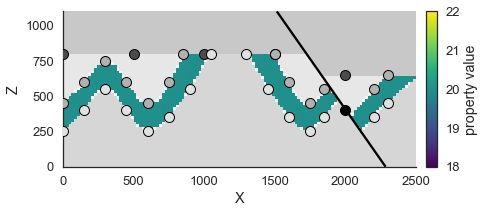

In [116]:
solution.plot_results(geo_data=geo_data, prop='val', contour=False, direction='y', cell_number=0, alpha=0.7,
                          show_data=False, legend=True)

# SGS non-eucl?

In [442]:
importlib.reload(kriging)

<module 'gempy.assets.kriging' from '../../..\\gempy\\assets\\kriging.py'>

In [443]:
domain = kriging.domain(model=sol, domain=[4], data=cond_data, fault=True)

In [444]:
np.random.seed(10340)
# Manual way to input sgs stuff with scalar field values for non euclidian distance 
# nit nice but good enough for figure

geo_data.set_custom_grid(domain.data[:,:3])
gp.compute_model(geo_data, compute_mesh=False)

locs = np.hstack((domain.krig_grid, domain.krig_scal.reshape((len(domain.krig_grid),1)),domain.fault_model.reshape((len(domain.krig_grid),1))))
np.random.shuffle(locs)

sgs_locations = np.vstack((domain.data[:,:3], locs[:,:3]))
sgs_gradients = np.vstack((geo_data.solutions.custom[1][2].reshape((4,1)), locs[:,3].reshape((len(domain.krig_grid),1))))
sgs_fault_block = np.vstack((np.round(geo_data.solutions.custom[1][0].reshape((4,1))), locs[:,4].reshape((len(domain.krig_grid),1))))

sgs_grid = np.hstack((sgs_locations, sgs_gradients))
sol.grid.set_inactive('custom')

Active grids: ['regular' 'custom']


array([ True, False, False, False, False])

In [445]:
solution_sim = kriging.create_gaussian_field(domain, variogram_model, distance_type='deformed', 
                                             moving_neighbourhood='n_closest', sgs_grid=sgs_grid, shuffled_grid=locs,
                                            sgs_fault_block=sgs_fault_block)

(521, 521)
0.0


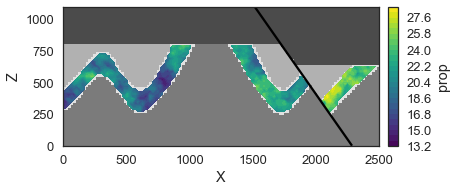

In [446]:
#solution_sim.plot_results(geo_data=geo_data, prop='val', contour=True, direction='y', cell_number=1, alpha=0.9,
                          #show_data=False, legend=True)

#plt.savefig('test_figure5.svg')

In [447]:
sgs_locations[16]

array([910.        ,  39.84      , 630.82962963])

In [448]:
sgs_locations[:,2]

array([500.        , 500.        , 550.        , ..., 448.96296296,
       691.45185185, 267.0962963 ])

In [449]:
np.where(sgs_locations[:,0]==790)

(array([  22,  224,  307,  322,  427,  573,  778,  854,  865,  941, 1032,
        1267, 1387, 1422, 1444, 1497, 1619, 1623, 1666, 1698, 1720, 1726,
        1762, 1805], dtype=int64),)

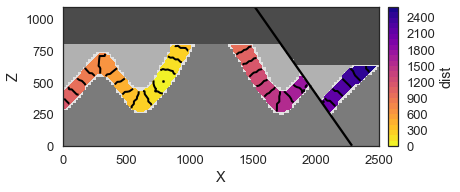

In [450]:
point=423

solution_sim.plot_distances(geo_data=geo_data, direction='y', cell_number=1, point=point,
                            contour=True, alpha=0.5,  interpolation='nearest', legend=True)

plt.scatter(sgs_locations[point+4][0], sgs_locations[point+4][2], color='black', s=5)

plt.savefig('test_figure4.svg')